In [668]:
import torch 
from pyro import poutine
import numpy as np
from pyro.infer.autoguide.initialization import init_to_sample
from collections import defaultdict
import pyro as pyro
from pyro import plate
from torch.distributions.dirichlet import Dirichlet as dirichlet
import pyro.distributions as dist
from torch.distributions import constraints
from pyro.distributions import Dirichlet, Gamma

In [669]:
from pyro import poutine
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete


In [801]:
# Here I will wefine all of the constants
num_people = 10000
num_questions = 30

#I will assume that each question has the same number of levels (options)
num_levels = 3

# Say there are only republicans and democrats
num_profiles = 2

In [802]:
# data generation process 
def generate_data(): 
    # This will contain the "true values"
    params = {}
    
    params['alpha_0'] = pyro.sample('alpha_0',dist.Gamma(1,1))
    xi_dist = Dirichlet(torch.ones(num_profiles))
    params['xi'] = pyro.sample('xi', xi_dist)
    alpha = params['xi'] * params['alpha_0']
    
    
    
    #Shape [num_people, num_profiles]
    #Determines membership of each person to the profiles
    with plate("g_vals", size = num_people):
        params['g'] = pyro.sample('g',Dirichlet(alpha))
    
    #Here I determine the values for the lambda
    #Shape [num_profiles, num_questions, num_levels]
    #First index determines extreme profile 
    #Second index determines question analized
    #Third index determines probabilities of levels
    with plate('question_probabilities', size=num_questions):
        with plate('pure_profiles', size=num_profiles):
            params['lambdas'] = pyro.sample('lambda', Dirichlet(torch.ones(num_profiles,num_questions,num_levels) * 0.4))

    #Here I determine the values for the Z
    #Shape [num_people, num_questions]
    #First index determines the person to  analyze
    #Second index determines the profile assumed in question
    with plate('profile_in_question', size=num_questions):
        with plate('profile_assumed_p', size=num_people):
            g_altered = torch.ones(num_questions,num_people,num_profiles) * params['g'] #trick to duplicate data
            g_altered = g_altered.permute(1,0,2) # Change axis to match what i find inutitive
            params['profile_assumed'] = pyro.sample('profiles_assumed',dist.Categorical(g_altered))
            
                                             
    #There are the survey answers
    #Shape [num_people,num_questions]
    #First index represents person who answered the survey
    #Second index represents number of the question
    with plate('answers_questions', size=num_questions) as questions: 
        with plate('answers_person', size=num_people): 
            #Clever indexing and batching tricks 
            # I am sorry about this I struggled finding a simpler way to do this
            # This is certainly bad style and should be corrected I am just not quite sure how
            range_questions = torch.arange(num_questions, dtype=torch.long)
            range_questions = torch.ones(num_people,num_questions,dtype=torch.long) * range_questions
            effective_lambdas = params['lambdas'][params['profile_assumed'],range_questions]
            params['answers'] = pyro.sample('answers', dist.Categorical(effective_lambdas))
            
        
        
    return params

In [806]:
trace = poutine.trace(generate_data).get_trace()
print(trace.format_shapes())

              Trace Shapes:                
               Param Sites:                
              Sample Sites:                
               alpha_0 dist             |  
                      value             |  
                    xi dist             | 2
                      value             | 2
                g_vals dist             |  
                      value       10000 |  
                     g dist       10000 | 2
                      value       10000 | 2
question_probabilities dist             |  
                      value          30 |  
         pure_profiles dist             |  
                      value           2 |  
                lambda dist     2    30 | 3
                      value     2    30 | 3
   profile_in_question dist             |  
                      value          30 |  
     profile_assumed_p dist             |  
                      value       10000 |  
      profiles_assumed dist 10000    30 |  
                      value 1000

In [807]:
params = generate_data()

print("The true parameters are: ")
for param in params: 
    print("-"*20)
    print(param + ":")
    print(params[param].shape)
    print(params[param])

The true parameters are: 
--------------------
alpha_0:
torch.Size([])
tensor(0.6900)
--------------------
xi:
torch.Size([2])
tensor([0.2827, 0.7173])
--------------------
g:
torch.Size([10000, 2])
tensor([[7.5286e-01, 2.4714e-01],
        [9.6083e-04, 9.9904e-01],
        [9.0591e-01, 9.4091e-02],
        ...,
        [3.2623e-01, 6.7377e-01],
        [1.0992e-07, 1.0000e+00],
        [9.3850e-01, 6.1503e-02]])
--------------------
lambdas:
torch.Size([2, 30, 3])
tensor([[[7.9632e-01, 1.9335e-01, 1.0332e-02],
         [3.9245e-01, 6.0650e-01, 1.0499e-03],
         [1.2393e-01, 1.4919e-01, 7.2687e-01],
         [2.7279e-03, 2.8053e-01, 7.1674e-01],
         [2.9775e-01, 5.8610e-01, 1.1615e-01],
         [9.0197e-01, 9.4245e-02, 3.7839e-03],
         [4.4061e-01, 7.9977e-02, 4.7942e-01],
         [4.9585e-02, 7.7392e-01, 1.7649e-01],
         [6.1280e-01, 3.0120e-01, 8.6005e-02],
         [3.4853e-03, 9.0477e-01, 9.1743e-02],
         [9.3327e-02, 9.0126e-01, 5.4136e-03],
         [2.4

In [808]:

@config_enumerate
def model(data): 
    alpha_0 = pyro.sample('alpha_0',dist.Gamma(2,1))
    xi_dist = Dirichlet(torch.ones(num_profiles))
    xi = pyro.sample('xi', xi_dist)
    alpha = xi * alpha_0
    
    
    
    #Shape [num_people, num_profiles]
    #Determines membership of each person to the profiles
    with plate("g_vals", size = num_people):
        g = pyro.sample('g',Dirichlet(alpha))
    
    #Here I determine the values for the lambda
    #Shape [num_profiles, num_questions, num_levels]
    #First index determines extreme profile 
    #Second index determines question analized
    #Third index determines probabilities of levels
    with plate('question_probabilities', size=num_questions):
        with plate('pure_profiles', size=num_profiles):
            lambdas = pyro.sample('lambda', Dirichlet(torch.ones(num_profiles,num_questions,num_levels)))

    #Here I determine the values for the Z
    #Shape [num_people, num_questions]
    #First index determines the person to  analyze
    #Second index determines the profile assumed in question
    with plate('profile_in_question', size=num_questions):
        with plate('profile_assumed_p', size=num_people):
            g_altered = torch.ones(num_questions,num_people,num_profiles) * g #trick to duplicate data
            g_altered = g_altered.permute(1,0,2) # Change axis to match what i find inutitive
            profile_assumed = pyro.sample('profiles_assumed',dist.Categorical(g_altered))
            
                                             
    #There are the survey answers
    #Shape [num_people,num_questions]
    #First index represents person who answered the survey
    #Second index represents number of the question
    with plate('answers_questions', size=num_questions) as questions: 
        with plate('answers_person', size=num_people): 
            #Clever indexing and batching tricks 
            # I am sorry about this I struggled finding a simpler way to do this
            # This is certainly bad style and should be corrected I am just not quite sure how
            range_questions = torch.arange(num_questions, dtype=torch.long)
            range_questions = torch.ones(num_people,num_questions,dtype=torch.long) * range_questions
            effective_lambdas = lambdas[profile_assumed,range_questions]
            answers = pyro.sample('answers', dist.Categorical(effective_lambdas), obs=data)



In [809]:
def guide(data): 
    k_gamma = pyro.param('k_gamma', torch.tensor(1.0), constraint=constraints.positive)
    theta_gamma = pyro.param('k_gamma', torch.tensor(1.0), constraint=constraints.positive)
    xi_means = pyro.param('xi_means', torch.ones(num_profiles), constraint=constraints.positive)
    alpha = pyro.param('alpha', torch.ones((num_people,num_profiles)), constraint=constraints.positive) 
    lambdas_val = pyro.param('lambda_vals', torch.ones((num_profiles,num_questions,num_levels)), constraint=constraints.positive)
    
    alpha_0 = pyro.sample('alpha_0', Gamma(k_gamma,theta_gamma))
    xi = pyro.sample('xi', Dirichlet(xi_means))
    with plate("g_vals", size = num_people):
        g = pyro.sample('g',Dirichlet(alpha))

    with plate('question_probabilities', size=num_questions):
        with plate('pure_profiles', size=num_profiles):
            lambdas = pyro.sample('lambda', Dirichlet(lambdas_val))
    
    

Now this is all stuff related to training. We did here two things to marginalize the $Z$ first we use the ``@config_enumerate`` decorator. The second thing is that when using the auto delta we only expose the parameters which are not discrete.  Finally, we used as our loss TraceEnum_Elbo instead of the regular ELBO. I am not a hundered percent sure how all of this works. I know that you should use this from looking at the documentation, but I don't understand precisely how this works. 

In [791]:
optim = pyro.optim.Adam({'lr': 0.05, 'betas':[0.09,0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=2)


In [810]:
# Register hooks to monitor gradient norms.
pyro.clear_param_store()
svi = SVI(model,guide,optim,loss=elbo)
gradient_norms = defaultdict(list)
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(lambda gu, name=name: gradient_norms[name].append(gu.norm().item()))

losses = []
for i in range(1200):
    loss = svi.step(params['answers'])
    losses.append(loss)
    if i % 200 == 0: 
        print(loss)
        print(i)


173116.9375
0
39686.8671875
200
32512.48828125
400
27239.90234375
600
26002.828125
800
25862.9765625
1000


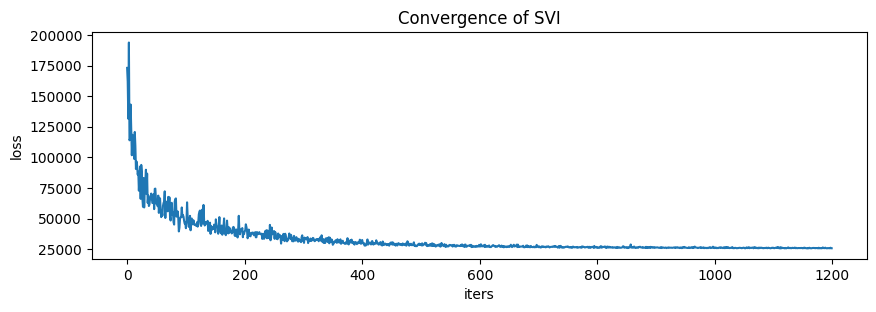

In [811]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
plt.plot(losses)
plt.xlabel('iters')
plt.ylabel('loss')
plt.title('Convergence of SVI');


So we see that this converges quite nicely now we can take a look at the predicted values of the parameters

In [ ]:
from pyro.infer import Predictive 

num_samples = 20000
predictive = Predictive(model, guide=guide,num_samples=num_samples)
samples = {k: v.detach().cpu().numpy()
               for k, v in predictive(params['answers']).items()
               if k != "obs"}

In [ ]:
g_inf = samples['g'].mean(0)
g_real = params['g'].detach().numpy()

In [ ]:
g_inf2 = g_inf[0]


<AxesSubplot:>

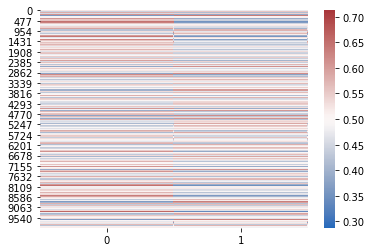

In [771]:
sbn.heatmap(g_inf2, cmap='vlag')

<AxesSubplot:>

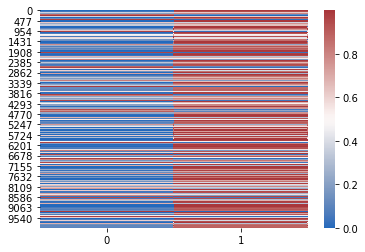

In [805]:
sbn.heatmap(params['g'].detach().numpy(),cmap='vlag')

<AxesSubplot:>

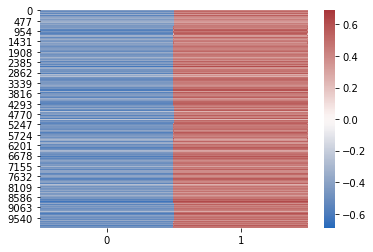

In [773]:
sbn.heatmap(g_inf2 - g_real, cmap='vlag')

In [775]:
g_inf[0] - g_real

array([[-0.51603496,  0.5160352 ],
       [-0.4906384 ,  0.49063858],
       [-0.45923316,  0.45923308],
       ...,
       [-0.47256595,  0.47256586],
       [-0.44084245,  0.44084227],
       [-0.46936584,  0.46936634]], dtype=float32)